# <center>TF-IDF with Python and Scikit Learn</center>

## Introduction

Up until now, we have explored the key concepts of TF-IDF. Here, we will begin to implement the TF-IDF algorithm from Scikit-Learn, but before we do that, we have to consider one very important thing: the state of our data. Whenever you are using algorithms, it is always *essential* to think about what form does the algorithm expect. The first part of this notebook will, therefore, be dedicated to explaining the data and preparing it for the TF-IDF algorithm.

## Preparing the Data

In this section of the notebook we will begin importing and manipulating and working with our TRC dataset and in order to do that you need to be familiar with how to import JSON data in Python so in this first block of code we will be doing just that.  I always find that writing out a basic function for reading Json data is always useful because you can use the function throughout your script without having to write 3 lines of code and instead simply writing one. We are going to call this function load_data.

With this function now in place we can import our JSON data that contains our TRC data set which is under the data subfolder. In the next line, we call this function to achieve that task.

In [7]:
import pandas as pd
df = pd.read_csv("../data/trc.csv")
df.head(3)

,ObjectId,Last,First,Description,Place,Yr,Homeland,Province,Long,Lat,HRV,ORG
0,1,AARON,Thabo Simon,An ANCYL member who was shot and severely inju...,Bethulie,1991.0,NaN,Orange Free State,25.97552,-30.503290,shoot|injure,ANC|ANCYL|Police|SAP
1,2,ABBOTT,Montaigne,A member of the SADF who was severely injured ...,Messina,1987.0,NaN,Transvaal,30.039597,-22.351308,injure,SADF
2,3,ABRAHAM,Nzaliseko Christopher,A COSAS supporter who was kicked and beaten wi...,Mdantsane,1985.0,Ciskei,Cape of Good Hope,27.6708791,-32.958623,beat,COSAS|Police


Now that we have loaded the data, let's create two separate objects, one for the anmes in the dataset and another for the descriptions. There are better ways to do this in Python with libraries like Pandas, but I do not want to introduce another library into the mix in this textbook.

In [12]:
descriptions = df.Description.tolist()
print (len(descriptions))

20834


Now that we have the objects created, it's probably a good idea to print of the first index of each to make sure that they are what we expect and to print off the length of each list to make sure that they are the same length.

In [11]:
print (descriptions[0])

An ANCYL member who was shot and severely injured by SAP members at Lephoi, Bethulie, Orange Free State (OFS) on 17 April 1991. Police opened fire on a gathering at an ANC supporter's house following a dispute between two neighbours, one of whom was linked to the ANC and the other to the SAP and a councillor.


This is precisely what we want to see. Both lists are the same length and index 0 for names aligns with the correct corresponding description. This is also a good chance to see what this data looks like. This description is a fair representation of the format and length of all other descriptions in this dataset.

Below, we will use the names to plot the data on a graph, but for now we will strictly be working with the descriptions list. The reason for this is because these are the texts that we want to cluster through TF-IDF and K-Means.

## Cleaning the Data

Now that we have the data that we need for processing, it is time to start cleaning the data. When cleaning text for TF-IDF and topic modeling, it is often good practice to remove certain things from the text that may throw off the algorithms. The specific things you choose to remove from texts will vary depending on the texts you are working with, but there are generally certain words for each language that you will want to remove. These are called **stop words**.

In English, stop words will be articles, such as `'the', 'an', and 'a' or the verb 'to be'`. These words are often removed from texts because they occur so frequently that they offer nothing unique about the texts at hand. In other words, they are so common that they do not aid in the clustering of texts. This is because clustering seeks to find particular features of texts and then identify the texts with common overlapping features. Stop words would make all texts overlap significantly. We remove these words to force clustering to focus on the more important words.

In addition to this, we also often need to develop our own stop words for these specific texts, or a general domain. In our case, these texts have a lot of dates and AC numbers that correspond to other records. While these are significant pieces of metadata, these both throw off the clustering. If we were interested in seeing how dates overlap, there are better ways of performing that task. For those interested, see my <a href="ner.pythonhumanities.com">Named Entity Recognition Textbook</a>.

The functions below will clean our text in the above mentioned manner. There are annotations to explain each section of the code.

In order to run the code below, though, we will first need to download a list of stopwords from NLTK.

In [61]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wjbmattingly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
import string
from nltk.corpus import stopwords
import re

def remove_stops(text, stops):
    #uses regex to remove all AC numbers
    text = re.sub(r"AC\/\d{1,4}\/\d{1,4}", "", text)
    
    #removes all stop words, including months
    words = text.split()
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
            
    #reassembles the text without stop words
    final = " ".join(final)
    
    #removes all punctuation
    final = final.translate(str.maketrans("", "", string.punctuation))
    
    #removes all numbers
    final = "".join([i for i in final if not i.isdigit()])
    
    #eliminates double white spaces
    while "  " in final:
        final = final.replace("  ", " ")
    return (final)

def clean_docs(docs):
    #gets the NLTK's stopword list for English
    stops = stopwords.words("english")
    
    #empty new list to store the cleaned docs
    final = []
    
    #iterate over all docs and cleans them to be a
    #single sentence with no unwanted words
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.append(clean_doc)
    
    return (final)

Now comes the time to clean all of our documents. We will use one line of code to pass all descriptions to clean_docs().

In [19]:
cleaned_docs = clean_docs(descriptions)

After cleaning my documents, I always find it is good to print off a sample of the before and after to see that my functions are working as intended. So, let's do that here.

In [20]:
print ("Original Text:")
print (descriptions[0]+"\n")

print ("Cleaned Text:")
print (cleaned_docs[0])

Original Text:
An ANCYL member who was shot and severely injured by SAP members at Lephoi, Bethulie, Orange Free State (OFS) on 17 April 1991. Police opened fire on a gathering at an ANC supporter's house following a dispute between two neighbours, one of whom was linked to the ANC and the other to the SAP and a councillor.

Cleaned Text:
An ANCYL member shot severely injured SAP members Lephoi Bethulie Orange Free State OFS April Police opened fire gathering ANC supporters house following dispute two neighbours one linked ANC SAP councillor


As we can see from these two outputs, the original text has been heavily altered and cleaned. Notice, for example, the removal of the date. Now that we have the data fully cleaned, it is time to begin setting up the TF-IDF algorithm with Scikit-Learn.

## Implementing TF-IDF in Python

Implementing TF-IDF in Python requires us to import a few things from the Scikit Learn library. Remember, in Python Scikit Learn is "sklearn". So, let's import those things now.

In [21]:
# A lot of this section comes from the Scikit Learn documentation and various blogs including the following:
#https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

First, we import the TfidfVectorizer. This is going to be what allows us to perform TF-IDF in just a few lines of code. Second, we import KMeans. This will be what allows us to cluster the TF-IDF of each key word in each text.

Now that we have the libraries imported, we can begin to work with them. First, let's make our vectorizer. This will be our TF-IDF algorithm. It will have several functions that we can call. For now, though, let's focus on the parameters.

| Parameter    | Description                                                                                                                                                                                                                                                                                |
|--------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| lowercase    | allows us to lowercase our data.                                                                                                                                                                                                                                                           |
| max_features | this is how many words out of the entire corpus we want to take into account. Here, we will use 100. The higher the number, the more computational expensive the tasks are to run. I have chosen 100 for this demonstration somewhat at random, but it works fairly well for our purposes. |
| max_df       | this is a float that tells the algorithm to ignore any word that occurs in 80% of the documents.                                                                                                                                                                                           |
| min_df       | this is an integer that tells the algorithm to ignore words that do not occur more than 5 times in the entire corpus.                                                                                                                                                                      |
| ngram_range  | this is a tuple with index 0 being the smallest number of words to consider with the second index being the largest, i.e. 2 for bigram and 3 for trigrams. (1, 3) means the algorithm should consider anything from a unigram (one word) to trigram (three words) as a concept.            |
| stop_words   | this is the language you are working with and you are telling the algorithm to ignore the predefined set of stopwords. This is a bit excessive since we already did this with NLTK.                                                                                                        |

In [22]:
vectorizer = TfidfVectorizer(
                                lowercase=True,
                                max_features=100,
                                max_df=0.8,
                                min_df=5,
                                ngram_range = (1,3),
                                stop_words = "english"

                            )

Now that we have created the vectorizer, let's pass our documents to the algorithm with the method `fit_transform()`. This will pass all documents to the algorithm and vectorize them.

In [23]:
vectors = vectorizer.fit_transform(cleaned_docs)

Here, we can see the results of the vectors of the first document. This output is a tuple which indicates the keyword and the TF-IDF score. In this form, however, it is a bit hard to decipher. 

In [25]:
print(vectors[0])

  (0, 5)	0.29723901061151475
  (0, 36)	0.25289259755817356
  (0, 92)	0.1676996522871345
  (0, 2)	0.3397934181035764
  (0, 72)	0.2633613181991394
  (0, 6)	0.30627778192110294
  (0, 56)	0.19535436966172204
  (0, 77)	0.5016519391534785
  (0, 41)	0.23459044720002845
  (0, 80)	0.29258951458997623
  (0, 82)	0.18554060799440944
  (0, 55)	0.27579282750338985


In [26]:
feature_names = vectorizer.get_feature_names()

/home/wjbmattingly/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


By using the method `get_feature_names()`, we can get an easier to read text representation of our key words. Let's look at the most common first.

In [29]:
print(feature_names[0])

allegedly


In [28]:
dense = vectors.todense()

By using the method todense(), we can convert that vector into a larger representation and each word's TF-IDF score. Each number corresponds to a word. Those words that are keywords have a TF-IDF score, while those represented by 0 are words that did not make it into our max_features. In other words, they are irrelevant words.

In [30]:
print(dense[0])

[[0.         0.         0.33979342 0.         0.         0.29723901
  0.30627778 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.2528926  0.         0.         0.         0.         0.23459045
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.27579283 0.19535437 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.26336132 0.         0.         0.         0.         0.50165194
  0.         0.         0.29258951 0.         0.18554061 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.16769965 0.         0.         0.
  0.         0. 

To work with this data, let's reconvert it into a list with the command below.

In [31]:
denselist = dense.tolist()

This is what that same data looks like when printed off as a list. Again, this is our first document represented with its TF-IDF scores for each word.

In [32]:
print(denselist[0])

[0.0, 0.0, 0.3397934181035764, 0.0, 0.0, 0.29723901061151475, 0.30627778192110294, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25289259755817356, 0.0, 0.0, 0.0, 0.0, 0.23459044720002845, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27579282750338985, 0.19535436966172204, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2633613181991394, 0.0, 0.0, 0.0, 0.0, 0.5016519391534785, 0.0, 0.0, 0.29258951458997623, 0.0, 0.18554060799440944, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1676996522871345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Now, let's convert every document from its TF-IDF scores to a list of key words. This will be essential for clustering below. In the code below, we run each description across the denselist and check if each word appears in the denselist. If it does (i.e. if it is one of the 100 important max feature words), then we keep it and append that list of words to all_keywords. This object will be all the documents in a list. Each index (document) will now be a list of words.

In [33]:
all_keywords = []
for description in denselist:
    x=0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)

Let's take a look at what we have been able to do to our document 0 by looking at its original state, cleaned state, and just the key words.

In [62]:
print("Original Text:")
print(descriptions[0]+"\n")

print("Cleaned Text:")
print(cleaned_docs[0]+"\n")

print("Only Keywords Text:")
print(all_keywords[0])

Original Text:
An ANCYL member who was shot and severely injured by SAP members at Lephoi, Bethulie, Orange Free State (OFS) on 17 April 1991. Police opened fire on a gathering at an ANC supporter's house following a dispute between two neighbours, one of whom was linked to the ANC and the other to the SAP and a councillor.

Cleaned Text:
An ANCYL member shot severely injured SAP members Lephoi Bethulie Orange Free State OFS April Police opened fire gathering ANC supporters house following dispute two neighbours one linked ANC SAP councillor

Only Keywords Text:
['anc', 'anc supporters', 'april', 'house', 'injured', 'member', 'members', 'police', 'sap', 'severely', 'shot', 'supporters']


## K-Means Clustering

Now that our data is nothing more than a list of lists of key words for each document, we can use these features to see where there is overlap. This is called clustering and one method of clustering is K-Means which seeks to place every document into a cluster to which it has the most similarity. In the below code, we define true_k as the number of clusters. In this example, I am telling it to find 5 clusters. In the video below, I used 20, but as we will see for plotting it is easier to have 5.

In [48]:
true_k = 5
model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

Now that we have created the K-Means model, its time to cluster the data. We will do this by fitting the vectors to the model. In this scenario, we are using the TF-IDF scores from the descriptions to formulate the basis for our clusters.

In [49]:
model.fit(vectors)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

/home/wjbmattingly/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now that we have done that, let's see what our 5 clusters look like as arrays. These arrays are a list of the keywords most associated with each cluster represented by their numerical value.

In [50]:
print(order_centroids)

[[72 56 55 21 28 82 15  2 61 80 16 96 41 78 60 94 95 88 48 54 98 47 81  0
  10 97 25 45 35 29 11 22 79 17 86 73 26 24 14 46 69  6 83 44  3  1 99 84
  87 66 77 36 67 92 32  7 31 33 71 34 18 64 12 74 76 58 30 38 13 70  8 62
  27  5  9 51 42 90 23 68 40 75 49 50 43 65 52 37 39  4 59 91 53 93 57 89
  20 19 63 85]
 [38  2 82 92 83 24 88 90 40  3 62  4 91 64 22  5 51 52 41 39 73 87  7  6
  11 48  0 61 74 76 25 96 84 30 56 54 79 26 35 14 93 42 12 66 46 32 23 69
  75 97 65 31 67 47 60 55 43 29 44 45 80 72 71 98 53 18 36  1 86 13 77 49
  50 70 99 34 33 15 57 10 21 78 37 68 63 81  8 17 27 58 95  9 19 20 89 16
  85 28 94 59]
 [92 18 64 36 38 30 22 35  2 51 52 42  8 40 88 73 74 11 65  7 85 53 62  9
  89 43 19  3 20 37  5 32 49 98 54 50 27 23 63 75 13 93  6 25 87  0 48 39
  44 46 12 26 60 99 69 47 31 61 41 76 82 66 14 79 67 70 80 55 56  1 71 29
  34 33 96 84 24 72 15 90 83 10 81 16 97 77 45 17 57 21 86  4 95 78 94 68
  91 28 58 59]
 [58 68  1 33 34 41 59 48 69 11 96 70 56 71 78 47 17 46 13 55 24 64

Let's look at the first word from the first cluster, number 92. We can find that word by looking it up in our terms list.

In [51]:
print(terms[92])

supporters


Since we can do that with one word, we can automate the entire process of converting all numbers into a list of key words for each cluster with the below code. Here, I am limiting the list to just the first 10 words for each cluster.

In [64]:
for i, cluster in enumerate(order_centroids[:1]):
    print (f"Cluster {i}")
    for keyword in cluster[0:10]:
        print (terms[keyword])
    print ("")

Cluster 0
police
members
member
cape
detained
shot
beaten
anc
named
severely



And Viola, just like that we have all 22,000 descriptions clusterd into 5 categories. I know what you may be thinking, though. How do we see where those documents are. The answer is addressed below when we plot the data. In order to walk through this portion of notebook, check out the video below.

## Plotting the Data

This portion of the notebook is perhaps best illustrated with the video below. The code below has already been executed so that you can see the data plotted out on a graph. Each node on the graph represents a description. Each color represents a cluster.

In [53]:
#A lot of this section was obtained from https://stackoverflow.com/questions/27494202/how-do-i-visualize-data-points-of-tf-idf-vectors-for-kmeans-clustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [54]:
kmean_indices = model.fit_predict(vectors)

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())

In [55]:
colors = ["r", "b", "m", "y", "c"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

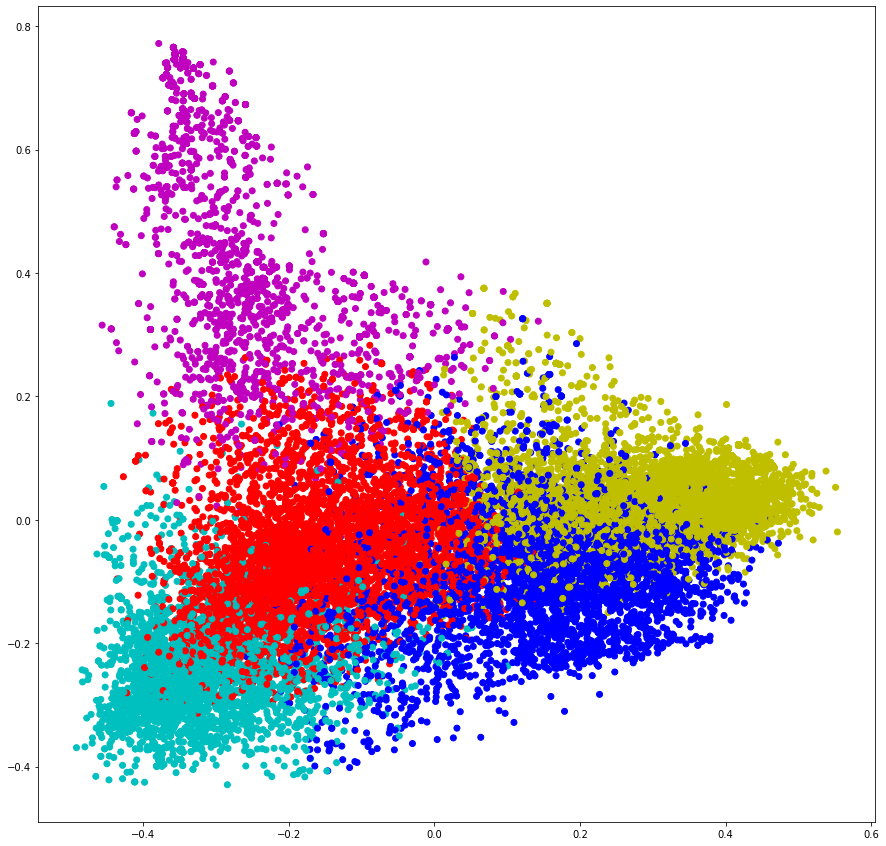

In [59]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])